# Integrative analysis of pathway deregulation in obesity
### The obesity score correlates with Body Mass Index
We show that the obesity score correlates with BMI in several independent validation datasets. The obesity score a simple metric computed from the expression of the 38 genes of the signature,

$$
S_j = \sum_{i=1}^{38} \alpha_i X_{ji}
$$

where $\alpha_i$ is the $i$-th ranked gene in the obesity signature, and $X_{ji}$ is the expression of gene $i$ in sample $j$. This notebook reproduces figures 1, 2 and 6 in

F. Font-Clos, S. Zapperi, C.A.M. La Porta  
Integrative analysis of pathway deregulation in obesity  
*npj Systems Biology and Applications (accepted)*, 2017  
[insert link](link). 



In [1]:
import numpy as np
import pandas as pd

from __future__ import division
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys

from scipy.stats import linregress,ks_2samp

/Users/fran/miniconda2/envs/obesity-score/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Load SVD-merged Batch 1-4
We load batches 1 to 4, which we have merged with a two-step SVD-filtering process in [this notebook](1. Two-step SVD-filtering to remove batch effects.ipynb).

In [2]:
geno1234 = pd.read_pickle("../output/batches1-4_merged/batch1234_geno.p")
pheno1234 = pd.read_pickle("../output/batches1-4_merged/batch1234_pheno.p")

### Load validation batches, Batch 5 to Batch 9
We also load independent validation batches:

In [3]:
# Batch 5
geno5  = pd.read_pickle("../data/gene_expression/GSE62117_geno.p")
pheno5 = pd.read_pickle("../data/gene_expression/GSE62117_pheno.p")

# Batch 6
geno6  = pd.read_pickle("../data/gene_expression/GSE64567_geno.p")
pheno6 = pd.read_pickle("../data/gene_expression/GSE64567_pheno.p")

# Batch 7
geno7  = pd.read_pickle("../data/gene_expression/GSE33526_geno.p")
pheno7 = pd.read_pickle("../data/gene_expression/GSE33526_pheno.p")

# Batch 8
geno8  = pd.read_pickle("../data/gene_expression/GSE78958_geno.p")
pheno8 = pd.read_pickle("../data/gene_expression/GSE78958_pheno.p")


### Clinical data polishing
We need to uniformize all the clinical data. Each batch has different columns in the **pheno** dataframe, but we need all of them to have at least these two columns:
+ **cbmi** (categorical bmi): the BMI status. A string, either "lean", "overweight" or "obese".
+ **bmi**: the numerical BMI in kg/m$^2$. Either a float or np.nan if not known.

We define a function to transform bmi to cbmi:


In [4]:
def bmi_to_cbmi(x):
    assert type(x) is float or type(x) is np.float64
    if x<=25:
        return "lean"
    elif x<=30:
        return "overweight"
    else:
        return "obese"

In [5]:
pheno5["bmi"] = pheno5.bmi.astype(float)
pheno5["cbmi"] = pheno5.bmi.astype(float).apply(bmi_to_cbmi)
pheno6["bmi"] = pheno6["bmi (kg/m2)"].astype(float)
pheno6["cbmi"] = pheno6.bmi.apply(bmi_to_cbmi)
pheno7["bmi"] = pheno7.bmi.astype(float)
pheno7["cbmi"] = pheno7.bmi.apply(bmi_to_cbmi)
pheno6["BMI"] = pheno6.bmi
pheno6["FPI"] = pheno6["fasting plasma insulin (\xce\xbcu/ml)"].astype(float)
pheno6["FPG"] = pheno6["fasting plasma glucose (mg/dl)"].astype(float)

Batch 8 contains 20 patients with Unknown bmi. We remove those:

In [6]:
idx = pheno8.loc[pheno8.bmi==" Unk"].index
pheno8.drop(idx,axis=0,inplace=True)
geno8.drop(idx,axis=0,inplace=True)

And map cathegorical bmi classes:

In [7]:
pheno8["cbmi"]=0
for lab,df in pheno8.groupby("bmi"):
    if lab==" <25":
        pheno8.loc[df.index,"cbmi"]="lean"
    if lab==" 25-29.99":
        pheno8.loc[df.index,"cbmi"]="overweight"
    if lab==" 30+":
        pheno8.loc[df.index,"cbmi"]="obese"
pheno8["bmi"]=np.nan

We normalize batches 5 to 9. Notice that batches 1 to 4 have already been normalized, **before** removing batch effects, see [this notebook](svd_filtering_batch_effects_removal.ipynb)

In [8]:
def normalize_df(df):
    
    # exponentiate
    x = pow(2.,df)
    
    # rows sum to 1
    x = x.div(x.sum(axis=1), axis=0)
    
    return np.log2(x)

In [9]:
geno5 = normalize_df(geno5)
geno6 = normalize_df(geno6)
geno7 = normalize_df(geno7)
geno8 = normalize_df(geno8)

### Compute Obesity Score
We load the obesity signature  (see [this notebook]()) and compute the obesity score for all datasets. All scores are given in mean-centered arbitrary units.

In [10]:
signature = pd.read_pickle("../output/signature/signature.p")
signature.index = signature.index.get_level_values(0)

In [11]:
def compute_score(geno,signature):
    common_genes = np.intersect1d(geno.columns,signature.index)
    rawscore = geno[common_genes].dot(signature.loc[common_genes].coef)
    return rawscore - np.mean(rawscore)

In [12]:
pheno1234["score"] = compute_score(geno1234,signature)
pheno5["score"] = compute_score(geno5,signature)
pheno6["score"] = compute_score(geno6,signature)
pheno7["score"] = compute_score(geno7,signature)
pheno8["score"] = compute_score(geno8,signature)

In [ ]:
### save batches for other notebooks
# geno5.to_pickle("../output/batches5-9_normalized/batch5_geno.p")
# pheno5.to_pickle("../output/batches5-9_normalized/batch5_pheno.p")
#
# geno6.to_pickle("../output/batches5-9_normalized/batch6_geno.p")
# pheno6.to_pickle("../output/batches5-9_normalized/batch6_pheno.p")
#
# geno7.to_pickle("../output/batches5-9_normalized/batch7_geno.p")
# pheno7.to_pickle("../output/batches5-9_normalized/batch7_pheno.p")
#
# geno8.to_pickle("../output/batches5-9_normalized/batch8_geno.p")
# pheno8.to_pickle("../output/batches5-9_normalized/batch8_pheno.p")

### Parameters for figures formatting
This helps plotting all figures with the same parameters and color palettes:

In [13]:
labelsize=16  # fontsize of x,y labels
title_size=18  # fontsize of the title       
ticks_size=14  # fontsize of numbers in x,y ticks
latex_size=18  # fontsize of latex-rendered pval, corr_coef annotations
xprop = 0.65   # relative x-position of latex-rendered pval, corr_coef annotations
yprop = 0.1    # relative y-position of latex-rendered pval, corr_coef annotations

In [14]:
colors_dict = {}
# obesity data
colors_dict["lean"] = sns.palettes.light_palette("green")[3]
colors_dict["overweight"] = sns.palettes.light_palette("orange")[3]
colors_dict["obese"] = sns.palettes.light_palette("red")[3]
# cancer data
colors_dict["NT"] = sns.palettes.light_palette("#f6ff42")[4]
colors_dict["TP"] = sns.palettes.light_palette("blue")[4]

### Figure 1e: boxplots for batches 1-4

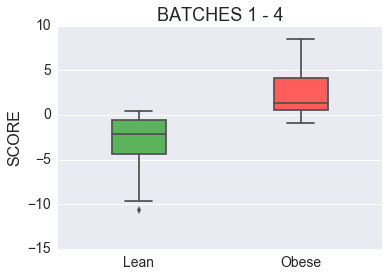

In [15]:
plt.figure(figsize=(6,4))

sns.boxplot(
    data = pheno1234,x="cbmi",y="score",
    order = ["lean","obese"],
    palette=colors_dict,
    saturation=1,
    width=0.5*2/3
)

xlim = plt.xlim()
ylim = plt.ylim()
plt.ylabel("SCORE",size=labelsize)
plt.xlabel("")
plt.title("BATCHES 1 - 4",size=title_size)

plt.subplots_adjust(left=0.15)
plt.xticks([0,1],["Lean","Obese"])
plt.tick_params(labelsize=ticks_size)
plt.savefig("../output/figures/Figure1e.pdf")
plt.show()

### Figure 2a: scatter plot for batch 3

In [16]:
pheno12341 = pheno1234.loc[~(pheno1234.bmi.isnull())]
pheno = pheno12341

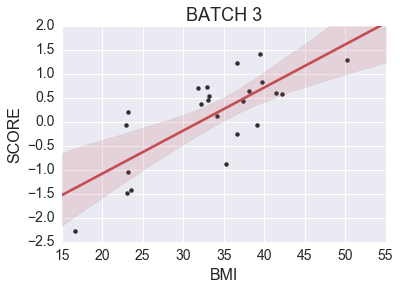

In [17]:
plt.figure(figsize=(6,4))
sns.regplot(pheno.bmi,pheno.score,fit_reg=False,color="black")
xlim = plt.xlim()
ylim = plt.ylim()
sns.regplot(pheno.bmi,pheno.score,\
            fit_reg=True,scatter=False,x_bins=6,x_estimator=np.mean,\
            color=sns.palettes.color_palette()[2])
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("BMI",size=labelsize)
plt.ylabel("SCORE",size=labelsize)
plt.title("BATCH 3",size=title_size)

plt.subplots_adjust(left=0.15,bottom=0.15)

plt.tick_params(labelsize=ticks_size)
if False:
    plt.text(xlim[0]+xprop*(xlim[1]-xlim[0]),
             ylim[0]+yprop*(ylim[1]-ylim[0]),
             "$R=0.75$",
             size=latex_size,
             horizontalalignment="left")

plt.savefig("../output/figures/Figure2a.pdf")
plt.show()


### Figure 2b: scatter plot for batch 5

In [18]:
pheno = pheno5
print "p=",linregress(pheno.bmi,pheno.score).pvalue
print "R=",linregress(pheno.bmi,pheno.score).rvalue

p= 7.30871268823e-07
R= 0.467426264452


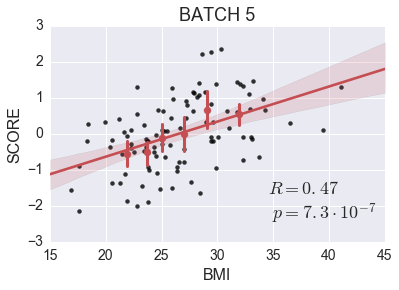

In [19]:
plt.figure(figsize=(6,4))
sns.regplot(pheno.bmi,pheno.score,fit_reg=False,color="black")
xlim = plt.xlim()
ylim = [-3,3]
sns.regplot(pheno.bmi,pheno.score,\
            fit_reg=True,scatter=True,x_bins=6,x_estimator=np.mean,\
            color=sns.palettes.color_palette()[2])
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("BMI",size=labelsize)
plt.ylabel("SCORE",size=labelsize)
plt.title("BATCH 5",size=title_size)

plt.subplots_adjust(bottom=0.15)

plt.tick_params(labelsize=ticks_size)
plt.text(xlim[0]+xprop*(xlim[1]-xlim[0]),
         ylim[0]+yprop*(ylim[1]-ylim[0]),
         "$R=0.47$ \n$\hspace{0.3}p=7.3 \cdot 10^{-7}$",
         size=latex_size,
         horizontalalignment="left")

plt.savefig("../output/figures/Figure2b.pdf")
plt.show()


### Figure 2c: scatter plot for batch 6

In [20]:
pheno = pheno6
print linregress(pheno.bmi,pheno.score).pvalue
print linregress(pheno.bmi,pheno.score).rvalue

2.67542195778e-07
0.591332262786


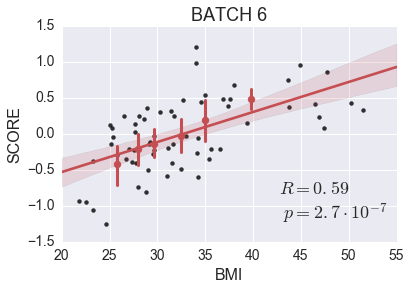

In [21]:
plt.figure(figsize=(6,4))
sns.regplot(pheno.bmi,pheno.score,fit_reg=False,color="black")
xlim = plt.xlim()
ylim = plt.ylim()
sns.regplot(pheno.bmi,pheno.score,\
            fit_reg=True,scatter=True,x_bins=6,x_estimator=np.mean,\
            color=sns.palettes.color_palette()[2])
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("BMI",size=labelsize)
plt.ylabel("SCORE",size=labelsize)
plt.title("BATCH 6",size=title_size)

plt.subplots_adjust(bottom=0.15)

plt.tick_params(labelsize=ticks_size)
plt.text(xlim[0]+xprop*(xlim[1]-xlim[0]),
         ylim[0]+yprop*(ylim[1]-ylim[0]),
         "$R=0.59$ \n$\hspace{0.3}p=2.7 \cdot 10^{-7}$",
         size=latex_size,
         horizontalalignment="left")

plt.savefig("../output/figures/Figure2c.pdf")
plt.show()

### Figure 2d: scatter plot for Batch 7

In [22]:
pheno = pheno7
print "p=",linregress(pheno.bmi,pheno.score).pvalue
print "R=",linregress(pheno.bmi,pheno.score).rvalue

p= 0.0220684300172
R= 0.269487772497


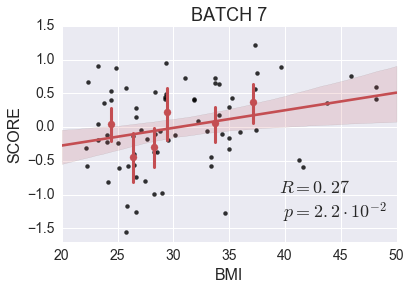

In [23]:
plt.figure(figsize=(6,4))
sns.regplot(pheno.bmi,pheno.score,fit_reg=False,color="black")
xlim = plt.xlim()
ylim = [-1.7,1.5]
sns.regplot(pheno.bmi,pheno.score,\
            fit_reg=True,scatter=True,x_bins=6,x_estimator=np.mean,\
            color=sns.palettes.color_palette()[2])
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("BMI",size=labelsize)
plt.ylabel("SCORE",size=labelsize)
plt.title("BATCH 7",size=title_size)

plt.subplots_adjust(bottom=0.15)

plt.tick_params(labelsize=ticks_size)
plt.text(xlim[0]+xprop*(xlim[1]-xlim[0]),
         ylim[0]+yprop*(ylim[1]-ylim[0]),
         "$R=0.27$ \n$\hspace{0.3}p=2.2 \cdot 10^{-2}$",
         size=latex_size,
         horizontalalignment="left")

plt.savefig("../output/figures/Figure2d.pdf")
plt.show()


### Figure 6: FPI and FPG scatter plots for batch 6, overweight only

In [24]:
bmi_min = 25
bmi_max = 30
pheno66 = pheno6.loc[ pheno6.bmi < bmi_max ].loc[ pheno6.bmi > bmi_min ]

In [25]:
pheno = pheno66
print linregress(pheno.FPG,pheno.score).pvalue
print linregress(pheno.FPG,pheno.score).rvalue

0.00274856547281
0.594955394286


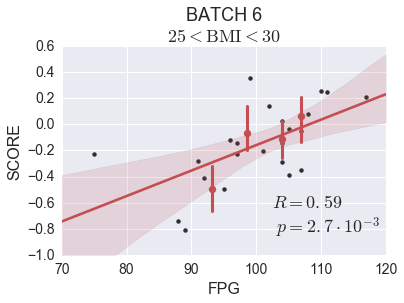

In [26]:
plt.figure(figsize=(6,4))
sns.regplot(pheno.FPG,pheno.score,fit_reg=False,color="black")
xlim = plt.xlim()
ylim = plt.ylim()
sns.regplot(pheno.FPG,pheno.score,\
            fit_reg=True,scatter=True,x_bins=4,x_estimator=np.mean,\
            color=sns.palettes.color_palette()[2])
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("FPG",size=labelsize)
plt.ylabel("SCORE",size=labelsize)
plt.title("BATCH 6\n$25 < \mathrm{BMI}<30$",size=title_size)


# only if double line title
plt.subplots_adjust(top=0.85,left=0.15)

plt.tick_params(labelsize=ticks_size)
plt.text(xlim[0]+xprop*(xlim[1]-xlim[0]),
         ylim[0]+yprop*(ylim[1]-ylim[0]),
         "$R=0.59$ \n$\hspace{0.3}p=2.7 \cdot 10^{-3}$",
         size=latex_size,
         horizontalalignment="left")

plt.savefig("../output/figures/Figure6d.pdf")
plt.show()


In [27]:
pheno = pheno66
print linregress(pheno.FPI,pheno.score).pvalue
print linregress(pheno.FPI,pheno.score).rvalue

0.0287879933045
0.455904771217


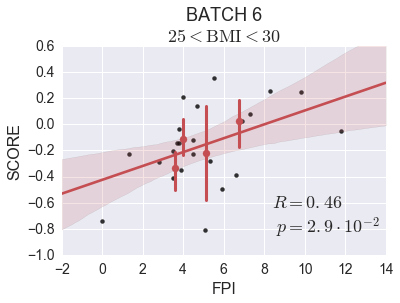

In [28]:
plt.figure(figsize=(6,4))
sns.regplot(pheno.FPI,pheno.score,fit_reg=False,color="black")
xlim = plt.xlim()
ylim = plt.ylim()
sns.regplot(pheno.FPI,pheno.score,\
            fit_reg=True,scatter=True,x_bins=4,x_estimator=np.mean,\
            color=sns.palettes.color_palette()[2])
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("FPI",size=labelsize)
plt.ylabel("SCORE",size=labelsize)
plt.title("BATCH 6\n$25 < \mathrm{BMI}<30$",size=title_size)

plt.subplots_adjust(top=0.85,left=0.15)

plt.tick_params(labelsize=ticks_size)
plt.text(xlim[0]+xprop*(xlim[1]-xlim[0]),
         ylim[0]+yprop*(ylim[1]-ylim[0]),
         "$R=0.46$ \n$\hspace{0.3}p=2.9 \cdot 10^{-2}$",
         size=latex_size,
         horizontalalignment="left")

plt.savefig("../output/figures/Figure6b.pdf")
plt.show()


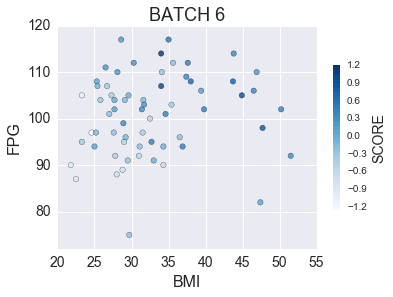

In [29]:
plt.figure(figsize=(6,4))
plt.scatter(pheno6.BMI,pheno6.FPG,
            c=pheno6.score,
            cmap="Blues",
            edgecolors="black",
            alpha=0.8,
            s=30
           )
plt.ylim([72,120])
plt.xlabel("BMI",size=labelsize)
plt.ylabel("FPG",size=labelsize)
plt.title("BATCH 6",size=title_size)

plt.subplots_adjust(left=0.15)
plt.tick_params(labelsize=ticks_size)
cb = plt.colorbar(shrink=0.65)
cb.set_label("SCORE",fontsize=ticks_size)

plt.savefig("../output/figures/Figure6c.pdf")
plt.show()

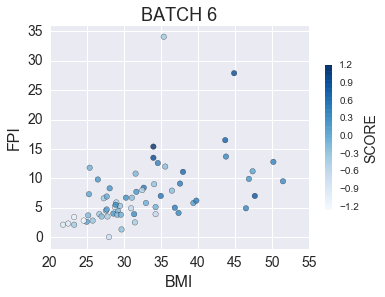

In [30]:
plt.figure(figsize=(6,4))
plt.scatter(pheno6.BMI,pheno6.FPI,
            c=(pheno6.score.values),
            cmap="Blues",
            edgecolors="black",
            alpha=0.8,
            s=30
           )
plt.ylim([-2,36])
plt.xlabel("BMI",size=labelsize)
plt.ylabel("FPI",size=labelsize)
plt.title("BATCH 6",size=title_size)

plt.subplots_adjust(left=0.15)
plt.tick_params(labelsize=ticks_size)
cb = plt.colorbar(shrink=0.65)
cb.set_label("SCORE",fontsize=ticks_size)

plt.savefig("../output/figures/Figure6a.pdf")
plt.show()